<a href="https://colab.research.google.com/github/alexparizeau/IEORE4524-P033B/blob/main/POS_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Set Up

In [ ]:
!pip install torch

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 880 kB 50.9 MB/s 
     |████████████████████████████████| 6.6 MB 27.6 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
     |████████████████████████████████| 96 kB 4.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=4bcb75f9e620a04528f40ad4a6fbcfa1777f9fa4f15f72de3ce3b782cb0e5376
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into a

In [ ]:
!pip install transformers seqeval[gpu]

     |████████████████████████████████| 43 kB 591 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=2da1e2ff485a4205e039127e70a4ca8458a145e96d3e8ab7b6e203553dac7240
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from sklearn.metrics import accuracy_score, classification_report
#from seqeval.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1. Supervised POS Models

## a) Conll Dataset (Standard English)

###Data Loading

In [ ]:
conll_train = drive.CreateFile({'id':'14dvjq020icKk21X0H2m2VLYIhHfe3ga0'}) 
conll_train.GetContentFile('Conll_train.txt')
conll_valid = drive.CreateFile({'id':'1MSJiPNgWKPuK2wOTeNBOnGqZR-Qvq6VV'}) 
conll_valid.GetContentFile('Conll_valid.txt')
conll_test = drive.CreateFile({'id':'1RYuoceeUyExeZdGJvPsSVzCBqDAbUUdp'}) 
conll_test.GetContentFile('Conll_test.txt')

### Data preprocessing

In [ ]:
def get_raw_df(txt_list):
  i = 0
  all_list = [sentence.strip().split() for sentence in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x and x[4] != "sentence 0"]
  df = pd.DataFrame(all_list, columns=["id", "pos_tags","chunk_tags","ner_tags", "sentence number"])
  return df

def get_preprocessed_df(txt_list, tag_name):
  raw_df = get_raw_df(txt_list)
  """tag_name is a string representing tag name from "pos_tags","chunk_tags","ner_tags" """
  raw_df["sentence"] = raw_df[["sentence number", "id", "pos_tags"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
  raw_df["labels"] = raw_df[["sentence number", "id", "pos_tags"]].groupby(["sentence number"])[tag_name].transform(lambda x: " ".join(x))
  return raw_df


In [ ]:
with open("Conll_train.txt") as f:
  train = f.readlines()
df_train_raw = get_preprocessed_df(train, "pos_tags")

with open("Conll_valid.txt") as f:
  valid = f.readlines()
df_valid_raw = get_preprocessed_df(valid, "pos_tags")

with open("Conll_test.txt") as f:
  test = f.readlines()
df_test_raw = get_preprocessed_df(test, "pos_tags")

In [ ]:
print(f"Length of train dataset: {len(df_train_raw)}, Length of validation dataset: {len(df_valid_raw)}, Length of test dataset: {len(df_test_raw)} ")

Length of train dataset: 204567, Length of validation dataset: 51578, Length of test dataset: 46666 


In [ ]:
labels_to_ids = {'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}
ids_to_labels = dict((v,k) for k,v in labels_to_ids.items())

In [ ]:
def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
df_train = get_sentence_labels(df_train_raw)
df_valid = get_sentence_labels(df_valid_raw)
df_test = get_sentence_labels(df_test_raw)

In [ ]:
df_train

In [ ]:
print(f"Length of train dataset: {len(df_train)}, Length of validation dataset: {len(df_valid)}, Length of test dataset: {len(df_test)} ")

### Change dataframe to PyTorch tensors 

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') #Bert using wordpiece *** may improve further

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.labels[index].split() 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, #no is_pretokenlized(Modification), we already have a splitted sentence
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1       

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
training_set = dataset(df_train, tokenizer, MAX_LEN)
validation_set = dataset(df_valid, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

### Tokenization Analysis

In [ ]:
def decoder(tensor_of_tokens):
  list_of_tokens = tensor_of_tokens.tolist()
  return tokenizer.convert_ids_to_tokens((list_of_tokens))

def token_analysis(line_num):
  """input a row of the training data you wish to look at"""
  input = df_train.iloc[line_num]['sentence']
  pos_labels = df_train.iloc[line_num]['labels']
  numerical_labels = training_set[line_num]['input_ids']
  label = decoder(training_set[line_num]['input_ids'])
  attn = training_set[line_num]['attention_mask']
  print(f'original sentence: {input}\n POS Tags: {pos_labels}\n Token IDs: {numerical_labels}\n Decoded Tokens: {label} \n Attention Masks: {attn}')

In [ ]:
token_analysis(22) #222 shows word piece splitting 

original sentence: RT @iceaxe5 : #cholera #haiti ... And how many lives ( and family providers ) would have been saved with faster warning & response .
 POS Tags: ~ @ ~ # # , & R A N , & N N , V V V V P A N & N ,
 Token IDs: tensor([  101, 19387,  1030,  3256,  8528,  2063,  2629,  1024,  1001, 25916,
         1001, 12867,  1012,  1012,  1012,  1998,  2129,  2116,  3268,  1006,
         1998,  2155, 11670,  1007,  2052,  2031,  2042,  5552,  2007,  5514,
         5432,  1004,  3433,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,   

### Build the model

### Train the model

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.244277000427246
Training loss per 100 training steps: 0.9602926969528198
Training loss per 100 training steps: 0.8355238437652588
Training loss per 100 training steps: 0.6532976627349854
Training loss per 100 training steps: 0.5435946583747864
Training loss per 100 training steps: 0.4813309609889984
Training loss per 100 training steps: 0.41956397891044617
Training loss per 100 training steps: 0.3989030122756958
Training loss per 100 training steps: 0.3652709126472473
Training loss per 100 training steps: 0.3389182388782501
Training loss per 100 training steps: 0.31545451283454895
Training loss per 100 training steps: 0.29849863052368164
Training loss per 100 training steps: 0.2832047641277313
Training loss per 100 training steps: 0.2676505148410797
Training loss per 100 training steps: 0.25448182225227356
Training loss per 100 training steps: 0.24340149760246277
Training loss per 100 training steps: 0.23153622448444366
Training

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model.to(device)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### Test the model

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels_conll, predictions_conll = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.5765858292579651
Validation loss per 100 evaluation steps: 0.08514627988166683
Validation loss per 100 evaluation steps: 0.09021025108068079
Validation loss per 100 evaluation steps: 0.09818781472868642
Validation loss per 100 evaluation steps: 0.0920739399212322
Validation loss per 100 evaluation steps: 0.09368502276023839
Validation loss per 100 evaluation steps: 0.1006063915864284
Validation loss per 100 evaluation steps: 0.0973066015040486
Validation loss per 100 evaluation steps: 0.09554475259917153
Validation loss per 100 evaluation steps: 0.10182160273517071
Validation loss per 100 evaluation steps: 0.09928708535496501
Validation loss per 100 evaluation steps: 0.1066447233639638
Validation loss per 100 evaluation steps: 0.10558185114991114
Validation loss per 100 evaluation steps: 0.10778211929813367
Validation loss per 100 evaluation steps: 0.10395088882258144
Validation loss per 100 evaluation steps: 0.09960441261274444
Validation Lo

In [ ]:
print(classification_report(list(labels_conll),list(predictions_conll)))

### Save the model for further use

In [ ]:
import os

directory = "./supervised_pos_Conll"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('Supervised POS Conll model saved')

## b) Gimpel et Al (Twitter)

###Data Loading

In [ ]:
gimpel_pos = drive.CreateFile({'id':"14UNwfhWzYYILrc3IG6frc-XyxU1x6MnL"})
gimpel_pos.GetContentFile("oct27.supertsv")

### Data Preprocessing

In [ ]:
def get_raw_df(txt_list):
  i = 0
  all_list = [sentence.strip().split() for sentence in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x and x[0] != '-TWEETSTART-']
  df = pd.DataFrame(all_list, columns=["id", "pos_tags", "sentence number","delete",])
  df = df.drop(['delete'],axis=1)
  return df

def get_preprocessed_df(txt_list, tag_name):
  raw_df = get_raw_df(txt_list)
  """tag_name is a string representing tag name from "pos_tags","chunk_tags","ner_tags" """
  raw_df["sentence"] = raw_df[["sentence number", "id", "pos_tags",]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
  raw_df["labels"] = raw_df[["sentence number", "id", "pos_tags"]].groupby(["sentence number"])[tag_name].transform(lambda x: " ".join(x))
  return raw_df


In [ ]:
labels_to_ids = {',':0, '&':1, '$':2, 'D':3,'X':4, 'G':5, 'P':6, 'A':7, 'V':8, 'N':9, '^':10, 'O':11, 'R':12, '!':13, 'S':14, 'Z':15, 'L':16, 'M':17, '#':18, '@':19, '~':20, 'U':21, 'E':22, 'T':23,'Y':24}
ids_to_labels = dict((v,k) for k,v in labels_to_ids.items())

In [ ]:
tweets = "oct27.supertsv"
data = open(tweets, "r",encoding='utf-8')
text = data.read()
texts = text.split('\n')
text_edit = list()
for item in texts:
  if item.startswith('TWEET\t'):
    text_edit.append('-TWEETSTART- -X-\n')
  elif item == 'TOKENS':
    text_edit.append('\n')
  elif item != '':
    token = item[2:]
    tag = item[0]
    text_edit.append(f'{token} {tag}\n')

In [ ]:
import sklearn.model_selection as sk_ms
full_tweets = get_preprocessed_df(text_edit,'pos_tags')
train_tweets, test_tweets = sk_ms.train_test_split(full_tweets, train_size=0.7,random_state=123,shuffle=True,stratify=full_tweets['labels'])

In [ ]:
test_tweets = test_tweets.reset_index()

In [ ]:
train_tweets = train_tweets[train_tweets['pos_tags'].isin(labels_to_ids.keys())]
test_tweets = test_tweets[test_tweets['pos_tags'].isin(labels_to_ids.keys())]

In [ ]:
train_tweets["pos_tags"].value_counts()

In [ ]:
def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
df_train = get_sentence_labels(train_tweets)
#df_valid = get_sentence_labels(df_valid)
df_test = get_sentence_labels(test_tweets)

In [ ]:
df_train

,sentence,labels
0,APPCRAFT software : T-Mobile Will Deliver The ...,"^ ^ , ^ V V D ^ ^ $ P ^ $ , ^ V R ~ U"
1,RT @AMGoHam : #Shoutouts to @theBEEzneez_ she ...,"~ @ ~ # P @ O V D A N , V V D N , D N P N , ~ ..."
2,now what i do hate is for a man to think its o...,R O O V V V P D N P V L A P V O P N @ #
3,Google : Different Algorithms Can Apply To Dif...,"^ , A N V V P A N P A N U P @"
4,I LOVE MY CELTICS !!!,"O V D ^ ,"
...,...,...
1810,@ChingyJackpot follow me6,@ V O
1811,http://dld.bz/y5fb,U
1812,i'm so hungry,L R A
1813,its #humpdayyy .,"L N ,"


In [ ]:
print(f"Length of train dataset: {len(df_train)}, Length of test dataset: {len(df_test)} ")

Length of train dataset: 1815, Length of test dataset: 1727 


### Change dataframe to PyTorch tensors 

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') #Bert using wordpiece *** may improve further

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.labels[index].split() 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, #no is_pretokenlized(Modification), we already have a splitted sentence
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1       

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
training_set = dataset(df_train, tokenizer, MAX_LEN)
validation_set = dataset(df_valid, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

###Building Train and Test Functions

In [ ]:
def train(epoch, modelx):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    modelx.train()
    
    for idx, batch in enumerate(training_loader):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = modelx(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, modelx.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=modelx.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
def valid(modelx, testing_loader):
    # put model in evaluation mode
    modelx.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = modelx(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, modelx.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

 ### i) BERT POS

#### Training and Testing

In [ ]:
from transformers import RobertaTokenizer,RobertaTokenizerFast,RobertaForTokenClassification, AutoModelForTokenClassification

MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', add_prefix_space=True) 

training_set = dataset(df_train, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
model2 = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(ids_to_labels))
model2.resize_token_embeddings(len(tokenizer))
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model2.to(device)
optimizer = torch.optim.Adam(params=model2.parameters(), lr=LEARNING_RATE)

##Train

for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch,model2)

## Test

labels, predictions = valid(model2, testing_loader)
print(classification_report(list(labels),list(predictions)))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Training epoch: 1
Training loss per 100 training steps: 3.303007125854492
Training loss per 100 training steps: 2.4594967365264893
Training loss per 100 training steps: 1.9063241481781006
Training loss per 100 training steps: 1.5344643592834473
Training loss per 100 training steps: 1.296858549118042
Training loss per 100 training steps: 1.1488431692123413
Training loss per 100 training steps: 1.0485862493515015
Training loss epoch: 1.0449070930480957
Training accuracy epoch: 0.7374204236748969
Training epoch: 2
Training loss per 100 training steps: 0.5768224000930786
Training loss per 100 training steps: 0.40800416469573975
Training loss per 100 training steps: 0.4040577709674835
Training loss per 100 training steps: 0.3721134662628174
Training loss per 100 training steps: 0.3536314368247986
Training loss per 100 training steps: 0.34490257501602173
Training loss per 100 training steps: 0.33695557713508606
Training loss epoch: 0.335644394159317
Training accuracy epoch: 0.919007113829627

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Saving to Directory

In [ ]:
import os

directory = "./pos_Bert_model_supervised"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model2.save_pretrained(directory)
print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


### ii) Bertweet Large POS

#### Training and Testing

In [ ]:
from transformers import RobertaTokenizer,RobertaTokenizerFast,RobertaForTokenClassification, AutoModelForTokenClassification
tokenizer = RobertaTokenizerFast.from_pretrained('vinai/bertweet-large', add_prefix_space=True) 
training_set = dataset(df_train, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
model2 = RobertaForTokenClassification.from_pretrained('vinai/bertweet-large', num_labels=len(ids_to_labels))
model2.resize_token_embeddings(len(tokenizer))
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model2.to(device)
optimizer = torch.optim.Adam(params=model2.parameters(), lr=LEARNING_RATE)

##Train

for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch,model2)

## Test

labels, predictions = valid(model2, testing_loader)
print(classification_report(list(labels),list(predictions)))


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/614 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN thi

Training epoch: 1


IndexError: ignored

#### Saving to Directory

In [ ]:
import os

directory = "./pos_Bertweet_model_supervised"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model2.save_pretrained(directory)
print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


### iii) Roberta POS

#### Training and Testing

In [ ]:
from transformers import RobertaTokenizer,RobertaTokenizerFast,RobertaForTokenClassification, AutoModelForTokenClassification
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True) 
training_set = dataset(df_train, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
model2 = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=len(ids_to_labels))
model2.resize_token_embeddings(len(tokenizer))
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model2.to(device)
optimizer = torch.optim.Adam(params=model2.parameters(), lr=LEARNING_RATE)

##Train

for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch,model2)

## Test

labels, predictions = valid(model2, testing_loader)
print(classification_report(list(labels),list(predictions)))


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

Training epoch: 1
Training loss per 100 training steps: 3.221292495727539
Training loss per 100 training steps: 2.284536600112915
Training loss per 100 training steps: 1.650243878364563
Training loss per 100 training steps: 1.3123759031295776
Training loss per 100 training steps: 1.1220260858535767
Training loss epoch: 1.0858522653579712
Training accuracy epoch: 0.724190485953213
Training epoch: 2
Training loss per 100 training steps: 0.8809526562690735
Training loss per 100 training steps: 0.42844945192337036
Training loss per 100 training steps: 0.39512425661087036
Training loss per 100 training steps: 0.3684934973716736
Training loss per 100 training steps: 0.3624682128429413
Training loss epoch: 0.35746556520462036
Training accuracy epoch: 0.9144826681089802
Training epoch: 3
Training loss per 100 training steps: 0.8251553177833557
Training loss per 100 training steps: 0.29501721262931824
Training loss per 100 training steps: 0.2745341360569
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Saving to Directory

In [ ]:
import os

directory = "./pos_Roberta_model_supervised"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model2.save_pretrained(directory)
print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


# 2. Unsupervised POS Model with Self-Training

## a) Step-by-Step

### Data Loading

In [ ]:
unlabelled_tweets = drive.CreateFile({'id':"1yssTP5EJQQLcE3oJi5LKqTYkznqm-pYK"})
unlabelled_tweets.GetContentFile("st_tweets.txt")

### Data Pre-Processing

In [ ]:
with open("st_tweets.txt") as f:
  new_tweets = f.readlines()

In [ ]:
def get_raw_df(txt_list):
  i = 1
  all_list = [token.split() for token in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x]
  df = pd.DataFrame(all_list, columns=["id", "tag", "sentence number"])
  return df

nt = get_raw_df(new_tweets)

In [ ]:
nt["sentence"] = nt[["sentence number", "id", "tag"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
nt["labels"] = nt[["sentence number", "id", "tag"]].groupby(["sentence number"])["tag"].transform(lambda x: " ".join(x))

def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
labels_to_ids = {',':0, '&':1, '$':2, 'D':3,'X':4 ,'G':5, 'P':6, 'A':7, 'V':8, 'N':9, '^':10, 'O':11, 'R':12, '!':13, 'S':14, 'Z':15, 'L':16, 'M':17, '#':18, '@':19, '~':20, 'U':21, 'E':22, 'T':23,'Y':24}
ids_to_labels = dict((v,k) for k,v in labels_to_ids.items())

In [ ]:
def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
df_train = get_sentence_labels(nt)
#df_valid = get_sentence_labels(df_valid)
df_test = get_sentence_labels(test_tweets)

In [ ]:
def label_sim(x):
  temp = x.split(" ")
  new = list()
  for i in temp:
    new.append("O")
  return " ".join(new)

df_train['labels'] = df_train['labels'].apply(lambda x:label_sim(x))

In [ ]:
df_train = df_train[0:2000]
df_train

### Zero-Shot Predictions

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, AutoConfig, BertForTokenClassification
pretrained_model_name = "/content/drive/MyDrive/pos_Bert_model_supervised"

def model_prediction(pretrained_model_name):
  from transformers import AutoModelForTokenClassification, AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name, add_prefix_space=True) 
  model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name)
  device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
  model.to(device)
  return model, tokenizer
model, tokenizer = model_prediction(pretrained_model_name)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }
training_set = dataset(df_train, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
def prediction(model, data_loader):
    all_sentences = []
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            sentence_prediction = {}
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)
 
            if idx % 100==0:
                print(f"Finished predicting {idx} sentences")
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # compute active probability using softmax function
            active_probability = torch.nn.functional.softmax(active_logits, dim=1)
            flattened_probability = torch.argmax(active_probability, axis=1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            probabilities = torch.masked_select(flattened_probability, active_accuracy)
            masks = torch.masked_select(mask, active_accuracy).tolist()
            input_ids = torch.masked_select(ids, active_accuracy).tolist()

            prob_score = []
            for ind, prob in enumerate(probabilities):
              prob_score.append(float(active_probability[ind][prob]))
            
            sentence_prediction["Attention masks"] = masks
            sentence_prediction["Input ids"] = input_ids
            sentence_prediction["Token"] = [tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids]
            sentence_prediction["Actual labels"] = [ids_to_labels[int(x)] for x in labels]
            sentence_prediction["Probability"] = [x for x in prob_score]
            sentence_prediction["Predicted labels"] = [ids_to_labels[int(x)] for x in predictions]
            sentence_prediction["Sentence number"] = [idx] * len(input_ids)
            all_sentences.append(sentence_prediction)

    return all_sentences

In [ ]:
predictions = prediction(model, training_loader)



In [ ]:
df_predictions = pd.DataFrame(predictions)


In [ ]:
df_predictions

In [ ]:
def save_directory(df, iteration_time = 0):
  df.to_csv(f"./processed_data_{iteration_time}.csv")  
  import os
  datafile = f"./processed_data_{iteration_time}.csv"
  d = f"processed_data_{iteration_time}.csv"
  directory = f'./unsupervised_selftraining_iteration_{iteration_time}'
  if not os.path.exists(directory):
      os.makedirs(directory)
  completeName = os.path.join(directory, d)
  f = open(completeName, "w")
  f.write(datafile)
  f.close()
  #!cp $datafile directory

In [ ]:
save_directory(df_predictions, iteration_time = 0)

In [ ]:
df_train

,sentence,labels
0,"I hate the words chunder , vomit and puke . BU...",O O O O O O O O O O O O
1,♥ . . ) ) ( ♫ . ( ) ♫ . ♥ . « ▓ » ♥ . ♫ . . ╝ ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Alesan kenapa mlm kita lbh srg galau Poconggg ...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,Complete Tosca on the tube http://t.co/O90deSLB,O O O O O O
4,Think you call that smash and grab . # Gateshe...,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...
1995,I wrote so much on the Tax Evasion question th...,O O O O O O O O O O O O O O O O O O O O O O O ...
1996,"Sigh , no1 takes me seriously",O O O O O O
1997,Need to revise for my exam on friday but I jus...,O O O O O O O O O O O O
1998,"revision is destroying me , i need alcohol .",O O O O O O O O O


### 1st Iteration

In [ ]:
def get_data(iteration_time):
  df_predictions = pd.read_csv(f"./processed_data_{iteration_time - 1}.csv")
  df_predictions = df_predictions.drop(columns=['Unnamed: 0'])
  import ast
  for column in list(df_predictions.columns):
    df_predictions[column] = df_predictions[column].apply(ast.literal_eval)
  #get the average predicted probability of each sentence to find the most confident sentences
  df_predictions["Average probability"] = df_predictions["Probability"].apply(np.mean)
  return df_predictions

In [ ]:
get_data(1).head()

,Attention masks,Input ids,Token,Actual labels,Probability,Predicted labels,Sentence number,Average probability
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10439, 4007, 1024, 1056, 2097, 8116, 1996, 25...","[app, software, :, t, will, deliver, the, blac...","[^, ^, ,, ^, V, V, D, ^, ^, $, P, ^, $, ,, ^, ...","[0.07004626095294952, 0.9835553765296936, 0.00...","[^, ^, ,, ^, V, V, D, ^, ^, $, P, ^, $, ,, ^, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.243032
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[19387, 1030, 1024, 1001, 2000, 1030, 2016, 20...","[rt, @, :, #, to, @, she, is, a, dan, fool, .,...","[~, @, ~, #, P, @, O, V, D, A, N, ,, V, V, D, ...","[0.01052755769342184, 0.00029815133893862367, ...","[~, @, ~, #, P, @, O, V, D, A, N, ,, V, V, D, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.034283
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2085, 2054, 1045, 2079, 5223, 2003, 2005, 103...","[now, what, i, do, hate, is, for, a, man, to, ...","[R, O, O, V, V, V, P, D, N, P, V, L, A, P, V, ...","[0.0101936561986804, 8.414717740379274e-05, 0....","[R, O, O, V, V, V, P, D, N, P, V, L, A, P, V, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.150034
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[8224, 1024, 2367, 13792, 2064, 6611, 2000, 23...","[google, :, different, algorithms, can, apply,...","[^, ,, A, N, V, V, P, A, N, P, A, N, U, P, @]","[0.13157965242862701, 0.0004314166435506195, 0...","[^, ,, A, N, V, V, P, A, N, P, A, N, U, P, @]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",0.075836
4,"[1, 1, 1, 1, 1]","[1045, 2293, 2026, 23279, 999]","[i, love, my, celtics, !]","[O, V, D, ^, ,]","[0.004911411087960005, 0.0002935265947598964, ...","[O, V, D, ^, ,]","[4, 4, 4, 4, 4]",0.001245


### Sentence-Level Selection & Prediction

In [ ]:
def new_split(df_train, iteration_time, top_percent = 0.10):
  import math
  df_predictions = get_data(iteration_time)
  #get sentences with predicted labels and replace the original true labels with the predicted most confident labels
  df_train["labels"] = df_predictions["Predicted labels"].str.join(" ")
  df_predictions = df_predictions.sort_values(by=['Average probability'], ascending=False)
  df_new_train = df_predictions.iloc[:(math.ceil(len(df_predictions) * top_percent)) + 1, : ]
  df_prediction = df_predictions.iloc[(math.ceil(len(df_predictions) * top_percent)) + 1:, : ]
  df_train_id = list(df_new_train.index)
  df_prediction_id = list(df_prediction.index)
  new_train = df_train.take(df_train_id)
  new_prediction = df_train.take(df_prediction_id)
  return new_train, new_prediction

In [ ]:
new_train, new_prediction = new_split(df_train, 1, top_percent = 0.10)

In [ ]:
new_train

,sentence,labels
1508,o____O,E
1796,O_o,E
1737,T______________________________________________T,E
1749,etc etc,G G
792,ROCKY HORROR #GLEE !!!,"^ ^ ^ ,"
...,...,...
510,Wait But Why Tho ?,"V & R R ,"
1448,Lamar,^
990,Offer Floating Form Capture Sites to All Sorts...,"V A N N N P D N P N & V V , U"
605,@MsYellaMulann @Ra_StayViolatin call us now lo...,@ @ V O R ! R R


In [ ]:
def update_model(new_train, tokenizer, iteration_time):
  train_params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }
  training_set = dataset(new_train, tokenizer, MAX_LEN)
  training_loader = DataLoader(training_set, **train_params)
  EPOCHS = 1
  for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)
  
  import os
  directory = f"./unsupervised_selftraining_iteration_{iteration_time}"

  if not os.path.exists(directory):
      os.makedirs(directory)

  # save vocabulary of the tokenizer
  tokenizer.save_vocabulary(directory)
  # save the model weights and its configuration file
  model.save_pretrained(directory)
  print(f'iteration {iteration_time} updated model saved')

In [ ]:
update_model(new_train, tokenizer, 1)

Training epoch: 1
Training loss per 100 training steps: 0.06677476316690445
Training loss per 100 training steps: 0.1011890172958374
Training loss per 100 training steps: 0.10542170703411102
Training loss per 100 training steps: 0.09702112525701523
Training loss per 100 training steps: 0.10318300127983093
Training loss per 100 training steps: 0.09993240982294083
Training loss per 100 training steps: 0.10043804347515106
Training loss per 100 training steps: 0.09880430996417999
Training loss per 100 training steps: 0.09754091501235962
Training loss per 100 training steps: 0.09413120895624161
Training loss per 100 training steps: 0.09354665130376816
Training loss per 100 training steps: 0.09267427027225494
Training loss per 100 training steps: 0.09263152629137039
Training loss per 100 training steps: 0.09272687137126923
Training loss per 100 training steps: 0.08996803313493729
Training loss per 100 training steps: 0.0881243646144867
Training loss per 100 training steps: 0.0893974006175994

###First test

In [ ]:
testing_set = dataset(df_test, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
labels_1st, predictions_1st = valid(model, testing_loader)
print(classification_report(labels_1st, predictions_1st))

Validation loss per 100 evaluation steps: 0.07998191565275192
Validation loss per 100 evaluation steps: 0.1656762727001442
Validation loss per 100 evaluation steps: 0.16346552662449468
Validation loss per 100 evaluation steps: 0.18683158838696023
Validation loss per 100 evaluation steps: 0.19791256939060986
Validation loss per 100 evaluation steps: 0.19198175886540883
Validation loss per 100 evaluation steps: 0.20564081422893948
Validation loss per 100 evaluation steps: 0.20183412099128242
Validation loss per 100 evaluation steps: 0.19707528134859104
Validation loss per 100 evaluation steps: 0.196503142492518
Validation loss per 100 evaluation steps: 0.1958039433520462
Validation loss per 100 evaluation steps: 0.1970498044220147
Validation loss per 100 evaluation steps: 0.20006484588934612
Validation loss per 100 evaluation steps: 0.20197266906995232
Validation loss per 100 evaluation steps: 0.1984124934890917
Validation loss per 100 evaluation steps: 0.19710656888221453
Validation los

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Save Model after first iteration

In [ ]:
def save_model(iteration_time = 1):
  import os
  #directory_0 = f'./unsupervised_selftraining_iteration_{iteration_time}'
  directory_1 = f'./unsupervised_selftraining_iteration_{iteration_time}/model'

  #if not os.path.exists(directory_0):
      #os.makedirs(directory_0)

  if not os.path.exists(directory_1):
      os.makedirs(directory_1)

  # save vocabulary of the tokenizer
  tokenizer.save_vocabulary(directory_1)
  # save the model weights and its configuration file
  model.save_pretrained(directory_1)
  print(f'tokenizer and model saved after {iteration_time} iteration ')

In [ ]:
save_model(iteration_time = 1)

tokenizer and model saved after 1 iteration 


### Produce Data for Next Iteration

In [ ]:
def get_new_prediction(new_prediction):
  new_prediction = new_prediction.reset_index(inplace = False)
  new_prediction = new_prediction.drop(columns="index")
  params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }
  prediction_set = dataset(new_prediction, tokenizer, MAX_LEN)
  prediction_loader = DataLoader(prediction_set, **params)
  predictions = prediction(model, prediction_loader)
  df_predictions = pd.DataFrame(predictions)
  return df_predictions

In [ ]:
new_prediction = new_prediction.reset_index(inplace = False)
new_prediction = new_prediction.drop(columns="index")
new_prediction

,sentence,labels
0,"RT @iheartquotes : "" Who are u chasin that's d...","~ @ ~ , O V O V L V O , O V O V L V D N , V , ..."
1,Ahh ... Bayou State Politics . Charlie Melanco...,"! ~ ^ N N , ^ ^ & ^ ^ V A N P ^ N N , U"
2,Yll wis u live in MIAMI,O V O V P ^
3,RT @PayPalx #xinnovate pays the cost of develo...,~ @ # V D N P N N R P V $ N P ^
4,RT @_twinklyToes What was that dance Nicki jus...,~ @ O V D N ^ R V O V V T
...,...,...
1627,@Broslife I RODE A TRICYCLE LAST NIGHT ! I'm g...,"@ O V D N A N , L V P V O P D N ,"
1628,"In November , bring a friend/refer a friend fo...","P ^ , V D N D N P ^ & O V $ P ,"
1629,Inspired after a yummy lunch with @erinepage ....,"V P D A N P @ , ! ,"
1630,"in town , dropped off photos , now having lunch !","P N , V T N , R V N ,"


In [ ]:
new_prediction

,sentence,labels
0,"RT @iheartquotes : "" Who are u chasin that's d...","~ @ ~ , O V O V L V O , O V O V L V D N , V , ..."
1,Ahh ... Bayou State Politics . Charlie Melanco...,"! ~ ^ N N , ^ ^ & ^ ^ V A N P ^ N N , U"
2,Yll wis u live in MIAMI,O V O V P ^
3,RT @PayPalx #xinnovate pays the cost of develo...,~ @ # V D N P N N R P V $ N P ^
4,RT @_twinklyToes What was that dance Nicki jus...,~ @ O V D N ^ R V O V V T
...,...,...
1627,@Broslife I RODE A TRICYCLE LAST NIGHT ! I'm g...,"@ O V D N A N , L V P V O P D N ,"
1628,"In November , bring a friend/refer a friend fo...","P ^ , V D N D N P ^ & O V $ P ,"
1629,Inspired after a yummy lunch with @erinepage ....,"V P D A N P @ , ! ,"
1630,"in town , dropped off photos , now having lunch !","P N , V T N , R V N ,"


In [ ]:
def get_model(iteration_time):
  from transformers import AutoModelForTokenClassification, AutoTokenizer
  pretrained_model_name = f'./unsupervised_selftraining_iteration_{iteration_time}/model'
  tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name, add_prefix_space=True) 
  model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name)
  device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
  model.to(device)
  return model, tokenizer
"""model, tokenizer = get_model(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }
prediction_set = dataset(new_prediction, tokenizer, MAX_LEN)
prediction_loader = DataLoader(prediction_set, **params)
predictions = prediction(model, prediction_loader)
predictions = pd.DataFrame(predictions)"""

"model, tokenizer = get_model(1)\noptimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)\n\nparams = {'batch_size': 1,\n                'shuffle': False,\n                'num_workers': 0\n                }\nprediction_set = dataset(new_prediction, tokenizer, MAX_LEN)\nprediction_loader = DataLoader(prediction_set, **params)\npredictions = prediction(model, prediction_loader)\npredictions = pd.DataFrame(predictions)"

In [ ]:
save_directory(predictions, iteration_time = 1)

In [ ]:
new_train, new_prediction = new_split(new_prediction, 2, top_percent = 0.10)

In [ ]:
new_train

,sentence,labels
918,@ayoki_lee -_- a hole,@ E ! !
905,Yayyyy Boston !,"! ! ,"
13,Unffffffff John Stamos unfffffffff,! ^ ^ !
1044,@meaghan_face herp derp,@ ! !
79,BRICK STRONG . RIP EVAN . <3,"^ ^ , ^ ^ , E"
...,...,...
838,Gothtober #BLANKtober,! #
228,' Rent Too Damn High ' NY candidate Jimmy McMi...,", N R R A , ^ N ^ ^ V N N , D U # #"
157,man for petesakes scratchh that sweepstakesss !,"! P N V D N ,"
598,RT @Shae_FreeDrizzy : No you're not twinn RT @...,"~ @ ~ ! L R N ~ @ ~ L A ,"


In [ ]:
new_prediction

,sentence,labels
156,"Everyone keeps telling me i need Jesus , i don...","N V V O O V ^ , O V V D ^ , O D N V O E"
825,Great Review on #JBSpinshttp :// jbspins.blogs...,A N P # U !
212,"@SkyHearDOTcom Your local and that's cool , hi...","@ D A & L A , V O T A V V P V R O V V ,"
160,I had forgotten how much i looove coffee cake ...,"O V V R R O V N N , ! , O V N N , ! ! ,"
161,now what i do hate is for a man to think its o...,R O O V V V P D N P V L A P V O P N @ #
...,...,...
1628,"In November , bring a friend/refer a friend fo...","P ^ , V D N D N P ^ & O V $ P ,"
1623,What is Paradise ... in the world ??,"O V N , P D N ,"
1631,i think its wrong people judge others by there...,"O V L A N V N P D N , O V P D N ,"
1630,"in town , dropped off photos , now having lunch !","P N , V T N , R V N ,"


#b) Iteration - Aggregated


### Load all Necessary Data

In [ ]:
gimpel_pos = drive.CreateFile({'id':"14UNwfhWzYYILrc3IG6frc-XyxU1x6MnL"})
gimpel_pos.GetContentFile("oct27.supertsv")

unlabelled_tweets = drive.CreateFile({'id':"1yssTP5EJQQLcE3oJi5LKqTYkznqm-pYK"})
unlabelled_tweets.GetContentFile("st_tweets.txt")


def get_raw_df_gimpel(txt_list):
  i = 0
  all_list = [sentence.strip().split() for sentence in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x and x[0] != '-TWEETSTART-']
  df = pd.DataFrame(all_list, columns=["id", "pos_tags", "sentence number","delete"])
  df = df.drop(['delete'],axis=1)
  return df

def get_raw_df_new(txt_list):
  i = 1
  all_list = [token.split() for token in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x]
  df = pd.DataFrame(all_list, columns=["id", "tag", "sentence number"])
  return df

labels_to_ids = {',':0, '&':1, '$':2, 'D':3,'X':4 ,'G':5, 'P':6, 'A':7, 'V':8, 'N':9, '^':10, 'O':11, 'R':12, '!':13, 'S':14, 'Z':15, 'L':16, 'M':17, '#':18, '@':19, '~':20, 'U':21, 'E':22, 'T':23,'Y':24}
ids_to_labels = dict((v,k) for k,v in labels_to_ids.items())

def get_preprocessed_df_gimpel(txt_list, tag_name):
  raw_df = get_raw_df_gimpel(txt_list)
  """tag_name is a string representing tag name from "pos_tags","chunk_tags","ner_tags" """
  raw_df["sentence"] = raw_df[["sentence number", "id", "pos_tags"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
  raw_df["labels"] = raw_df[["sentence number", "id", "pos_tags"]].groupby(["sentence number"])[tag_name].transform(lambda x: " ".join(x))
  return raw_df

data = open("oct27.supertsv", "r",encoding='utf-8')
text = data.read()
texts = text.split('\n')
text_edit = list()
for item in texts:
  if item.startswith('TWEET\t'):
    text_edit.append('-TWEETSTART- -X-\n')
  elif item == 'TOKENS':
    text_edit.append('\n')
  elif item != '':
    token = item[2:]
    tag = item[0]
    text_edit.append(f'{token} {tag}\n')

with open("st_tweets.txt") as f:
  new_tweets = f.readlines()
nt = get_raw_df_new(new_tweets)
nt["sentence"] = nt[["sentence number", "id", "tag"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
nt["labels"] = nt[["sentence number", "id", "tag"]].groupby(["sentence number"])["tag"].transform(lambda x: " ".join(x))

import sklearn.model_selection as sk_ms
full_tweets = get_preprocessed_df_gimpel(text_edit,'pos_tags')
train_tweets, test_tweets = sk_ms.train_test_split(full_tweets, train_size=0.7,random_state=123,shuffle=True)
train_tweets = train_tweets[train_tweets['pos_tags'].isin(labels_to_ids.keys())]
test_tweets = test_tweets[test_tweets['pos_tags'].isin(labels_to_ids.keys())]
test_tweets = test_tweets.reset_index()
train_tweets = train_tweets.reset_index()

def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)

df_train = get_sentence_labels(nt)
def label_sim(x):
  temp = x.split(" ")
  new = list()
  for i in temp:
    new.append("O")
  return " ".join(new)

df_train['labels'] = df_train['labels'].apply(lambda x:label_sim(x))
df_train = df_train[0:2000]
#df_valid = get_sentence_labels(df_valid)
df_test = get_sentence_labels(test_tweets)

### Define Functions

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.labels[index].split() 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, #no is_pretokenlized(Modification), we already have a splitted sentence
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1       

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
def prediction(model, data_loader):
    all_sentences = []
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            sentence_prediction = {}
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)
 
            if idx % 100==0:
                print(f"Finished predicting {idx} sentences")
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # compute active probability using softmax function
            active_probability = torch.nn.functional.softmax(active_logits, dim=1)
            flattened_probability = torch.argmax(active_probability, axis=1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            probabilities = torch.masked_select(flattened_probability, active_accuracy)
            masks = torch.masked_select(mask, active_accuracy).tolist()
            input_ids = torch.masked_select(ids, active_accuracy).tolist()

            prob_score = []
            for ind, prob in enumerate(probabilities):
              prob_score.append(float(active_probability[ind][prob]))
            
            sentence_prediction["Attention masks"] = masks
            sentence_prediction["Input ids"] = input_ids
            sentence_prediction["Token"] = [tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids]
            sentence_prediction["Actual labels"] = [ids_to_labels[int(x)] for x in labels]
            sentence_prediction["Probability"] = [x for x in prob_score]
            sentence_prediction["Predicted labels"] = [ids_to_labels[int(x)] for x in predictions]
            sentence_prediction["Sentence number"] = [idx] * len(input_ids)
            all_sentences.append(sentence_prediction)

    return all_sentences

In [ ]:
def get_data(iteration_time, model_name):
  df_predictions = pd.read_csv(f"./unsupervised_selftraining_{model_name}_iteration_{iteration_time-1}/processed_data_{iteration_time - 1}.csv")
  df_predictions = df_predictions.drop(columns=['Unnamed: 0'])
  import ast
  for column in list(df_predictions.columns):
    df_predictions[column] = df_predictions[column].apply(ast.literal_eval)
  #get the average predicted probability of each sentence to find the most confident sentences
  df_predictions["Average probability"] = df_predictions["Probability"].apply(np.mean)
  return df_predictions

In [ ]:
def new_split(df_train, iteration_time, model_name, top_percent = 0.10):
  import math
  df_predictions = get_data(iteration_time, model_name)
  #get sentences with predicted labels and replace the original true labels with the predicted most confident labels
  df_train["labels"] = df_predictions["Predicted labels"].str.join(" ")
  df_predictions = df_predictions.sort_values(by=['Average probability'], ascending=False)
  df_new_train = df_predictions.iloc[:(math.ceil(len(df_predictions) * top_percent)) + 1, : ]
  df_prediction = df_predictions.iloc[(math.ceil(len(df_predictions) * top_percent)) + 1:, : ]
  df_train_id = list(df_new_train.index)
  df_prediction_id = list(df_prediction.index)
  new_train = df_train.take(df_train_id)
  new_prediction = df_train.take(df_prediction_id)
  new_train = new_train.reset_index(drop=True)
  new_prediction = new_prediction.reset_index(drop=True)
  return new_train, new_prediction

In [ ]:
import os
def create_dir(i, tokenizer, model, model_name):
  directory_0 = f'./unsupervised_selftraining_{model_name}_iteration_{i}'
  directory_1 = f'./unsupervised_selftraining_{model_name}_iteration_{i}/model'

  if not os.path.exists(directory_0):
    os.makedirs(directory_0)

  if not os.path.exists(directory_1):
    os.makedirs(directory_1)

  # save vocabulary of the tokenizer
  tokenizer.save_vocabulary(directory_1)
  # save the model weights and its configuration file
  model.save_pretrained(directory_1)

In [ ]:
def update_model(new_train, tokenizer, iteration_time, model_name):

  for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)
  
  create_dir(iteration_time, tokenizer, model, model_name)
  
  print(f'iteration {iteration_time} updated model saved')

In [ ]:
def self_training_model(df_train, pretrained_model_path, model_name, top_percent = 0.20, total_iterations = 25):
  
  for i in range(total_iterations):
    print("==========================================================================")
    print(f"ITERATION {i} STARTS!")
    
    #zero-shot prediction
    if i == 0:
      #if model_name == "BERT":
        #tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path)
      #else:
      
      tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_path)
      print(f"tokenizer before iteration {i} loaded") 
      model = AutoModelForTokenClassification.from_pretrained(pretrained_model_path)
      print(f"model before iteration {i} loaded")
      model.to(device)
      
      #save the model and tokenizer in directory for further use
      create_dir(i, tokenizer, model, model_name)
      print(f'tokenizer and model saved after {i} iteration')
      
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      
      predictions = prediction(model, training_loader)
      predictions = pd.DataFrame(predictions)
      #save_directory(predictions, iteration_time = i)
      predictions.to_csv(f"./unsupervised_selftraining_{model_name}_iteration_{i}/processed_data_{i}.csv") 
      print(f'Iteration {i} Prediction data saved')
      print(f'ITERATION {i} ENDS!')
    
    #iteration starts
    else:
      from transformers import BertTokenizer
      model_previous = f'./unsupervised_selftraining_{model_name}_iteration_{i - 1}/model'
      tokenizer = BertTokenizerFast.from_pretrained(model_previous)
      model = AutoModelForTokenClassification.from_pretrained(model_previous)
      model.to(device)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

      #get the top percent most confident predictions from sentences and replace the labels with predictions
      new_train, new_prediction = new_split(df_train, i, model_name, top_percent)
      training_set = dataset(new_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      #return new_train, new_prediction
      #update the training model
      update_model(new_train, tokenizer, i, model_name)

      df_train = new_prediction
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      
      predictions = prediction(model, training_loader)
      predictions = pd.DataFrame(predictions)
      
      #save_directory(predictions, iteration_time = i)
      predictions.to_csv(f"./unsupervised_selftraining_{model_name}_iteration_{i}/processed_data_{i}.csv") 
      print(f'Iteration {i} Prediction data saved')
      print(f'ITERATION {i} ENDS!')



### Load Saved Model & Predict Labels

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
# choose BERT model from the previous model results
pretrained_model_path = "/content/drive/MyDrive/pos_Bert_model_supervised"
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
MAX_LEN = 128
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
self_training_model(df_train, pretrained_model_path = f"/content/drive/MyDrive/pos_Bert_model_supervised", top_percent = 0.10, total_iterations = 20, model_name = 'bert')

ITERATION 0 STARTS!
tokenizer before iteration 0 loaded
model before iteration 0 loaded
tokenizer and model saved after 0 iteration
Finished predicting 0 sentences
Finished predicting 100 sentences
Finished predicting 200 sentences
Finished predicting 300 sentences
Finished predicting 400 sentences
Finished predicting 500 sentences
Finished predicting 600 sentences
Finished predicting 700 sentences
Finished predicting 800 sentences
Finished predicting 900 sentences
Finished predicting 1000 sentences
Finished predicting 1100 sentences
Finished predicting 1200 sentences
Finished predicting 1300 sentences
Finished predicting 1400 sentences
Finished predicting 1500 sentences
Finished predicting 1600 sentences
Finished predicting 1700 sentences
Finished predicting 1800 sentences
Finished predicting 1900 sentences
Iteration 0 Prediction data saved
ITERATION 0 ENDS!
ITERATION 1 STARTS!
Training epoch: 1
Training loss per 100 training steps: 0.1650741994380951
Training loss per 100 training st

### Test Each Iteration on Test Set

In [ ]:
iteration = list()
validation_acc = list()
for i in [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]:
  iteration.append(i)
  print(f'TEST FOR ITERATION {i}')
  pretrained_model_path = f"/content/unsupervised_selftraining_bert_iteration_{i}/model"
  tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path, add_prefix_space=True)
  model = AutoModelForTokenClassification.from_pretrained(pretrained_model_path)
  model.to(device)
  testing_set = dataset(df_test, tokenizer, MAX_LEN)
  testing_loader = DataLoader(testing_set, **params)
  labels_10_percent, predictions_10_percent = valid(model, testing_loader)
  cr = classification_report(labels_10_percent, predictions_10_percent, output_dict=True)
  validation_acc.append(cr['accuracy'])
  print(classification_report(labels_10_percent, predictions_10_percent))

TEST FOR ITERATION 0
Validation loss per 100 evaluation steps: 0.08317039906978607
Validation loss per 100 evaluation steps: 0.09991497596688938
Validation loss per 100 evaluation steps: 0.09557142025508468
Validation loss per 100 evaluation steps: 0.1120252816650113
Validation loss per 100 evaluation steps: 0.11830760703823921
Validation loss per 100 evaluation steps: 0.11703591154583408
Validation loss per 100 evaluation steps: 0.12831346885364708
Validation loss per 100 evaluation steps: 0.1248453179654664
Validation loss per 100 evaluation steps: 0.12195654263715265
Validation loss per 100 evaluation steps: 0.12261124253820847
Validation loss per 100 evaluation steps: 0.12095476276465468
Validation loss per 100 evaluation steps: 0.11974230854197673
Validation loss per 100 evaluation steps: 0.12146936445811037
Validation loss per 100 evaluation steps: 0.12097090970886604
Validation loss per 100 evaluation steps: 0.11804427861898797
Validation loss per 100 evaluation steps: 0.1163501

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.93      0.97      0.95       665
           #       0.77      0.99      0.86       267
           $       0.94      0.98      0.96       380
           &       0.99      0.99      0.99       456
           ,       0.99      0.98      0.99      3031
           @       0.98      0.99      0.99      1233
           A       0.98      0.97      0.97      1344
           D       0.99      0.99      0.99      1614
           E       0.79      0.96      0.87       246
           G       0.77      0.48      0.59       257
           L       0.99      0.97      0.98       438
           M       0.00      0.00      0.00         3
           N       0.98      0.97      0.98      3582
           O       0.99      0.99      0.99      1848
           P       0.99      0.98      0.98      2281
           R       0.95      0.97      0.96      1219
           S       1.00      0.46      0.63        28
           T       0.92    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.83      0.96      0.89       665
           #       0.71      1.00      0.83       267
           $       0.92      0.97      0.94       380
           &       0.98      0.99      0.98       456
           ,       0.98      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.96      0.94      0.95      1344
           D       0.99      0.98      0.98      1614
           E       0.65      0.96      0.78       246
           G       0.71      0.37      0.49       257
           L       0.98      0.96      0.97       438
           M       0.00      0.00      0.00         3
           N       0.98      0.94      0.96      3582
           O       0.99      0.98      0.98      1848
           P       0.99      0.96      0.98      2281
           R       0.92      0.93      0.93      1219
           S       1.00      0.50      0.67        28
           T       0.81    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.90      0.94      0.92       665
           #       0.70      1.00      0.82       267
           $       0.89      0.98      0.93       380
           &       0.98      0.99      0.98       456
           ,       0.98      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.95      0.92      0.94      1344
           D       0.98      0.97      0.98      1614
           E       0.75      0.96      0.85       246
           G       0.64      0.42      0.51       257
           L       0.99      0.91      0.95       438
           M       0.00      0.00      0.00         3
           N       0.98      0.93      0.95      3582
           O       0.98      0.98      0.98      1848
           P       0.98      0.97      0.97      2281
           R       0.93      0.92      0.92      1219
           S       1.00      0.39      0.56        28
           T       0.86    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.87      0.94      0.90       665
           #       0.70      1.00      0.82       267
           $       0.90      0.97      0.94       380
           &       0.97      0.99      0.98       456
           ,       0.98      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.95      0.93      0.94      1344
           D       0.98      0.97      0.98      1614
           E       0.75      0.96      0.84       246
           G       0.66      0.40      0.50       257
           L       1.00      0.94      0.96       438
           M       0.00      0.00      0.00         3
           N       0.97      0.92      0.95      3582
           O       0.98      0.98      0.98      1848
           P       0.98      0.97      0.97      2281
           R       0.93      0.93      0.93      1219
           S       0.90      0.32      0.47        28
           T       0.83    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.91      0.93      0.92       665
           #       0.70      1.00      0.82       267
           $       0.86      0.98      0.92       380
           &       0.98      0.99      0.98       456
           ,       0.98      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.93      0.93      0.93      1344
           D       0.98      0.97      0.98      1614
           E       0.78      0.96      0.86       246
           G       0.55      0.45      0.49       257
           L       0.97      0.97      0.97       438
           M       0.00      0.00      0.00         3
           N       0.97      0.94      0.95      3582
           O       0.98      0.98      0.98      1848
           P       0.98      0.96      0.97      2281
           R       0.91      0.93      0.92      1219
           S       0.94      0.54      0.68        28
           T       0.84    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.89      0.93      0.91       665
           #       0.71      1.00      0.83       267
           $       0.90      0.97      0.93       380
           &       0.97      0.99      0.98       456
           ,       0.98      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.93      0.93      0.93      1344
           D       0.98      0.97      0.98      1614
           E       0.75      0.96      0.84       246
           G       0.60      0.42      0.50       257
           L       0.99      0.93      0.96       438
           M       0.00      0.00      0.00         3
           N       0.97      0.93      0.95      3582
           O       0.98      0.97      0.98      1848
           P       0.97      0.97      0.97      2281
           R       0.92      0.93      0.93      1219
           S       0.93      0.46      0.62        28
           T       0.82    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.84      0.94      0.89       665
           #       0.71      1.00      0.83       267
           $       0.89      0.97      0.93       380
           &       0.98      0.98      0.98       456
           ,       0.98      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.94      0.93      0.93      1344
           D       0.98      0.97      0.97      1614
           E       0.69      0.95      0.80       246
           G       0.51      0.43      0.47       257
           L       0.98      0.94      0.96       438
           M       0.00      0.00      0.00         3
           N       0.96      0.94      0.95      3582
           O       0.98      0.97      0.98      1848
           P       0.98      0.96      0.97      2281
           R       0.92      0.92      0.92      1219
           S       0.93      0.46      0.62        28
           T       0.85    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.80      0.95      0.87       665
           #       0.69      1.00      0.81       267
           $       0.89      0.97      0.93       380
           &       0.97      0.99      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.95      0.90      0.92      1344
           D       0.97      0.98      0.97      1614
           E       0.69      0.95      0.80       246
           G       0.59      0.37      0.45       257
           L       0.98      0.93      0.96       438
           M       0.00      0.00      0.00         3
           N       0.97      0.93      0.95      3582
           O       0.99      0.95      0.97      1848
           P       0.97      0.96      0.97      2281
           R       0.89      0.92      0.91      1219
           S       0.88      0.54      0.67        28
           T       0.83    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.84      0.94      0.88       665
           #       0.71      1.00      0.83       267
           $       0.92      0.96      0.94       380
           &       0.96      0.99      0.97       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.93      0.91      0.92      1344
           D       0.98      0.97      0.97      1614
           E       0.73      0.93      0.81       246
           G       0.59      0.41      0.48       257
           L       0.98      0.95      0.96       438
           M       0.00      0.00      0.00         3
           N       0.96      0.93      0.95      3582
           O       0.99      0.97      0.98      1848
           P       0.98      0.97      0.97      2281
           R       0.90      0.93      0.91      1219
           S       0.94      0.54      0.68        28
           T       0.86    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.82      0.94      0.88       665
           #       0.69      1.00      0.81       267
           $       0.87      0.98      0.92       380
           &       0.97      0.99      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.94      0.91      0.92      1344
           D       0.98      0.97      0.98      1614
           E       0.73      0.95      0.82       246
           G       0.55      0.42      0.47       257
           L       0.97      0.94      0.95       438
           M       0.00      0.00      0.00         3
           N       0.96      0.94      0.95      3582
           O       0.99      0.97      0.98      1848
           P       0.97      0.97      0.97      2281
           R       0.92      0.91      0.92      1219
           S       0.92      0.43      0.59        28
           T       0.82    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.81      0.95      0.87       665
           #       0.69      1.00      0.82       267
           $       0.88      0.97      0.92       380
           &       0.97      0.99      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.93      0.92      0.92      1344
           D       0.98      0.97      0.98      1614
           E       0.72      0.95      0.82       246
           G       0.57      0.39      0.47       257
           L       0.98      0.94      0.96       438
           M       0.00      0.00      0.00         3
           N       0.97      0.92      0.94      3582
           O       0.98      0.98      0.98      1848
           P       0.98      0.95      0.96      2281
           R       0.91      0.92      0.91      1219
           S       0.93      0.50      0.65        28
           T       0.82    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.87      0.93      0.90       665
           #       0.71      1.00      0.83       267
           $       0.90      0.97      0.93       380
           &       0.97      0.99      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.94      0.90      0.92      1344
           D       0.98      0.97      0.98      1614
           E       0.74      0.96      0.83       246
           G       0.53      0.43      0.48       257
           L       0.97      0.95      0.96       438
           M       0.00      0.00      0.00         3
           N       0.95      0.93      0.94      3582
           O       0.98      0.98      0.98      1848
           P       0.98      0.96      0.97      2281
           R       0.91      0.92      0.91      1219
           S       0.82      0.50      0.62        28
           T       0.81    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.79      0.94      0.86       665
           #       0.69      0.99      0.81       267
           $       0.86      0.97      0.91       380
           &       0.96      0.99      0.97       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.91      0.92      0.91      1344
           D       0.98      0.97      0.97      1614
           E       0.75      0.95      0.84       246
           G       0.52      0.38      0.44       257
           L       0.96      0.94      0.95       438
           M       0.00      0.00      0.00         3
           N       0.97      0.91      0.94      3582
           O       0.98      0.97      0.97      1848
           P       0.97      0.96      0.96      2281
           R       0.91      0.92      0.91      1219
           S       0.83      0.54      0.65        28
           T       0.84    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.83      0.94      0.88       665
           #       0.68      1.00      0.81       267
           $       0.88      0.97      0.92       380
           &       0.97      0.98      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.94      0.91      0.92      1344
           D       0.98      0.97      0.98      1614
           E       0.74      0.96      0.83       246
           G       0.57      0.37      0.45       257
           L       0.99      0.93      0.96       438
           M       0.00      0.00      0.00         3
           N       0.96      0.93      0.95      3582
           O       0.98      0.97      0.98      1848
           P       0.98      0.95      0.96      2281
           R       0.91      0.92      0.91      1219
           S       0.78      0.50      0.61        28
           T       0.84    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.89      0.92      0.91       665
           #       0.69      1.00      0.82       267
           $       0.88      0.97      0.92       380
           &       0.97      0.98      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.93      0.92      0.92      1344
           D       0.98      0.97      0.97      1614
           E       0.72      0.96      0.82       246
           G       0.58      0.40      0.47       257
           L       0.98      0.94      0.96       438
           M       0.00      0.00      0.00         3
           N       0.96      0.92      0.94      3582
           O       0.98      0.97      0.98      1848
           P       0.97      0.96      0.97      2281
           R       0.92      0.92      0.92      1219
           S       0.93      0.50      0.65        28
           T       0.83    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.85      0.94      0.89       665
           #       0.68      1.00      0.81       267
           $       0.88      0.97      0.92       380
           &       0.98      0.98      0.98       456
           ,       0.97      0.98      0.97      3031
           @       0.98      0.99      0.99      1233
           A       0.92      0.91      0.92      1344
           D       0.98      0.96      0.97      1614
           E       0.72      0.96      0.82       246
           G       0.52      0.42      0.47       257
           L       0.98      0.95      0.97       438
           M       0.00      0.00      0.00         3
           N       0.97      0.90      0.93      3582
           O       0.98      0.97      0.97      1848
           P       0.98      0.95      0.96      2281
           R       0.90      0.93      0.91      1219
           S       0.81      0.61      0.69        28
           T       0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.81      0.94      0.87       665
           #       0.68      1.00      0.81       267
           $       0.86      0.97      0.91       380
           &       0.98      0.98      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.91      0.91      0.91      1344
           D       0.98      0.97      0.97      1614
           E       0.77      0.92      0.84       246
           G       0.55      0.40      0.46       257
           L       0.98      0.95      0.96       438
           M       0.00      0.00      0.00         3
           N       0.96      0.92      0.94      3582
           O       0.97      0.98      0.97      1848
           P       0.98      0.95      0.97      2281
           R       0.91      0.91      0.91      1219
           S       0.77      0.36      0.49        28
           T       0.80    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.82      0.94      0.88       665
           #       0.68      1.00      0.81       267
           $       0.85      0.97      0.91       380
           &       0.97      0.99      0.98       456
           ,       0.97      0.98      0.98      3031
           @       0.98      0.99      0.99      1233
           A       0.92      0.91      0.91      1344
           D       0.98      0.97      0.97      1614
           E       0.77      0.93      0.84       246
           G       0.54      0.41      0.46       257
           L       0.97      0.94      0.96       438
           M       0.00      0.00      0.00         3
           N       0.97      0.89      0.93      3582
           O       0.98      0.97      0.97      1848
           P       0.97      0.95      0.96      2281
           R       0.90      0.92      0.91      1219
           S       0.78      0.50      0.61        28
           T       0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           !       0.82      0.94      0.87       665
           #       0.67      1.00      0.80       267
           $       0.87      0.97      0.92       380
           &       0.99      0.98      0.98       456
           ,       0.97      0.98      0.97      3031
           @       0.98      0.99      0.99      1233
           A       0.92      0.91      0.91      1344
           D       0.97      0.97      0.97      1614
           E       0.76      0.93      0.83       246
           G       0.49      0.42      0.45       257
           L       0.97      0.94      0.95       438
           M       0.00      0.00      0.00         3
           N       0.96      0.90      0.93      3582
           O       0.98      0.97      0.97      1848
           P       0.97      0.95      0.96      2281
           R       0.93      0.90      0.91      1219
           S       0.91      0.36      0.51        28
           T       0.80    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
training_acc = [0.9832061816675643, 0.9915116148886468, 0.9963239813027643, 0.996896048968625, 0.997583019148653, 0.9982412081235348, 0.9986991767146035, 0.9984213172189726, 0.9987608050583717, 0.9992337275768479, 0.999613115923455, 0.9992951771067535, 0.9993470284696347, 0.9994586071534086, 0.9995001245571722, 0.9990049958292523, 0.9994978013111345, 0.9996505143884221, 0.9994173092361026]

### Visualize Results

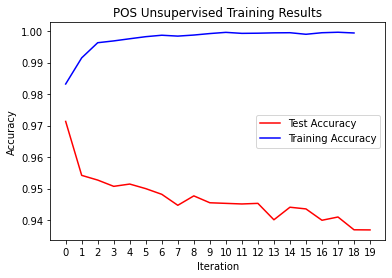

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('POS Unsupervised Training Results')
ax.plot(iteration,validation_acc, color='r')
ax.plot(range(19),training_acc, color='b')
ax.set_xlabel("Iteration")
ax.set_xticks(range(20))
ax.set_ylabel("Accuracy")

ax.legend(["Test Accuracy", "Training Accuracy"], loc=0)

